# Pruebas de segmentación con el Catálogo Morfológico de Nebulosas Planetarias del IAC (NO SUPERVISADO)
En este documento vamos a probar las técnicas comentadas por Diego Cantorna en el documento de astrogestem (disponible en la carpeta astrosegstem de este mismo repositorio) y vamos a añadir ciertas técnicas y mejoras. Todas las técnicas testeadas en este Jupyter Notebook son de aprendizaje supervisado.

## Carga del Dataset
Vamos a definir una clase, que tome como base la clase Dataset de Pytorch, para poder cargar todo nuestro conjunto de imágenes de uno o varios canales con su máscara correspondiente.

In [11]:
import os

print("Vamos a cambiar el directorio de trabajo")

# Indicamos la ruta del directorio de trabajo
route = os.getcwd() + "/TFG/test/PNe_segmentation"
os.chdir(route)

current_directory = os.getcwd()
print(" El directorio actual es:", current_directory)

# Listamos el contenido del directorio
files = os.listdir(current_directory)
print(" Contenido del directorio actual:")
for file in files:
    print("\t",file)
    
# Listamos el contenido del directorio de las máscaras
# masks_directory = route+"TFG\\test\\PNe_segmentation\\masks"
# data_directory = route+"TFG\\test\\PNe_segmentation\\data"
## Ejecución en el CESGA Finisterrae III
masks_directory = route+"/masks"
data_directory = route+"/data"


Vamos a cambiar el directorio de trabajo
 El directorio actual es: /mnt/netapp2/Home_FT2/home/ulc/co/ela/TFG/test/PNe_segmentation
 Contenido del directorio actual:
	 commands.txt
	 data
	 create_dataset.ipynb
	 data_files_1c.csv
	 images
	 launch_jupyter.sh
	 masks
	 segmentation_no_supervisada.ipynb
	 segmentation_no_supervisada_2c.ipynb
	 segmentation_no_supervisada_pytorch.ipynb
	 segmentation_supervisada.ipynb
	 dataset_info.csv
	 data_files_1c_train.csv
	 historico_notebooks
	 data_files_1c_test.csv
	 segmentation_no_supervisada_pytorch_clean.ipynb
	 segmentation_supervisada_pytorch copy.ipynb
	 segmentation_supervisada_pytorch.ipynb


In [12]:
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import random as rd
import numpy as np
from astropy.io import fits
from skimage import measure


MinMaxNorm = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

class NebulaeDataset(Dataset):
    
    def __init__(self, image_path, mask_path, dataframe, rsize = None, transform = None):
        super().__init__()
        
        self.image_path = image_path  # Ruta a las imágenes
        self.mask_path = mask_path  # Ruta a las máscaras
        
        # Cargar los nombres de las imágenes y máscaras desde el dataframe
        self.data_dict = dataframe.set_index('name').to_dict(orient='index')

        # Filtrar las rutas de archivo según los nombres en el dataframe
        self.img_files = [os.path.join(self.image_path, files['h']) for files in self.data_dict.values()]
        self.mask_files = [os.path.join(self.mask_path, files['mask']) for files in self.data_dict.values()]
        self.names = list(self.data_dict.keys())  # Nombres de las imágenes y máscaras
                
        self.rsize = rsize  # Size to use in default Resize transform
        self.transform = transform

    # Returns both the image and the mask
    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        
        image = np.flip(fits.getdata(img_path, memmap=False).astype(np.float32), axis=0)
        mask = plt.imread(mask_path)
        
        # Take only the first channel. CHANGE THIS IF WE ARE GOING TO WORK WITH NUMEROUS CHANNELS
        if len(mask.shape) > 2:
            mask = mask[:,:,0]
        if len(image.shape) > 2:
            image = image[:,:,0]
        
        # Apply the defined transformations to both image and mask
        if self.transform is not None:
            seed = np.random.randint(2147483647) # make a seed with numpy generator 
            rd.seed(seed) # apply this seed to image transforms
            torch.manual_seed(seed)
            if type(self.transform) == tuple:
                image = self.transform[0](image)
            else:
                image = self.transform(image)
            rd.seed(seed) # apply the same seed to mask transforms
            torch.manual_seed(seed) 
            if type(self.transform) == tuple:
                mask = self.transform[1](mask)
            else:
                mask = self.transform(mask)
        else:
            if self.rsize is not None:
                t = transforms.Compose([
                    MinMaxNorm,
                    transforms.ToTensor(),
                    transforms.Resize(self.rsize, interpolation= InterpolationMode.NEAREST)
                    ])
            else:
                t = transforms.Compose([
                    MinMaxNorm,
                    transforms.ToTensor()
                    ])

            image = t(image)
            mask = t(mask)
        
        return image, torch.round(mask).int()

    def __len__(self):
        return len(self.img_files)
    
    def different_shapes(self):
        shapes = set([tuple(self[i][0].permute(2,1,0).shape) for i in range(len(self))])
        return list(shapes)
    
    def plot(self, index, plot_image = True, plot_mask = False):
        """
        Muestra una imagen y/o máscara aleatoria del lote.
        
        Parámetros:
        index (int): Índice del lote.
        plot_image (bool, opcional): Si es True, muestra la imagen. Por defecto es True.
        plot_mask (bool, opcional): Si es True, muestra la máscara. Por defecto es False.
        """
        image, mask = self[index]
        image = image.permute(1,2,0)
        mask = mask.permute(1,2,0)
        name = self.names[index]
        
        if plot_image:
            fig, ax = plt.subplots(1, 1, figsize=(5, 5))
            fig.suptitle(f"Canales de la nebulosa {name}", fontweight = 'bold', fontsize = 14)
            ax.imshow(image, cmap = "gray")
            ax.set_title(f"Canal H")
            fig.show()
        if plot_mask:
            fig, ax = plt.subplots(1, 1, figsize=(5, 5))
            fig.suptitle(f"Máscara de la nebulosa {name}", fontweight = 'bold', fontsize = 14)
            ax.imshow(mask, cmap = "gray")
            fig.show()
            
    def different_shapes(self):
        shapes = set([tuple(self[i][0].permute(2,1,0).shape) for i in range(len(self))])
        return list(shapes)
    
    def bg_obj_proportions(self):
        proportions = []
        for i in range(len(self)):
            mask = self[i][1].numpy()
            bg = np.sum(mask == 0)
            obj = np.sum(mask == 1)
            proportions.append(obj/(bg+obj))
        return proportions
    
    def contrast_differences(self, radius = None):
        contrasts = []
        if radius is not None:
            for i in range(len(self)):
                image = self[i][0].numpy()
                mask = self[i][1].numpy()
                bg = image[mask == 0]
                obj = image[mask == 1]
                contrasts.append(np.mean(obj) - np.mean(bg))
        else:
            for i in range(len(self)):
                image = self[i][0].numpy()
                mask = self[i][1].numpy()
                
                bg = image[mask == 0]
                obj = image[mask == 1]
                contrasts.append(np.mean(obj) - np.mean(bg))
        return contrasts


Ahora deberíamos de ser capaces de poder cargar todas las imágenes, como tensores de PyTorch, de nuestro csv como un Dataset

In [13]:
import pandas as pd
df = pd.read_csv("data_files_1c_train.csv")
dataset = NebulaeDataset(data_directory, masks_directory, df)

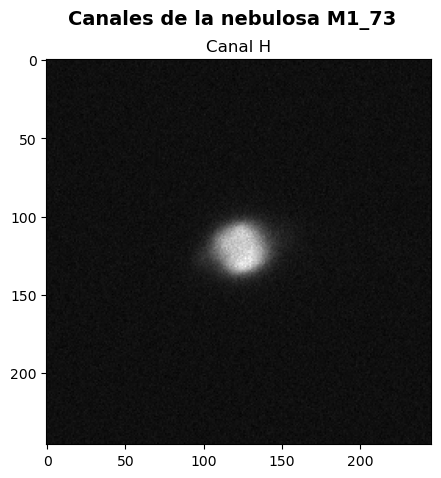

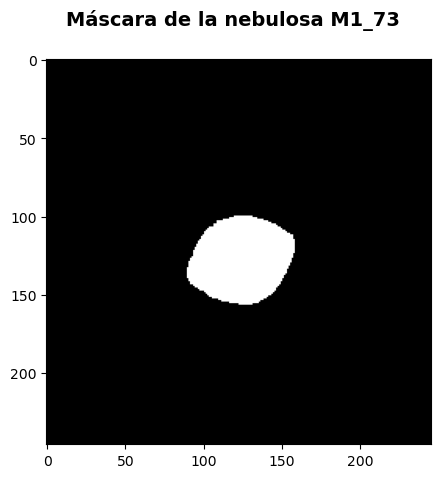

In [14]:
dataset.plot(119, plot_image = True, plot_mask = True)

## Segmentación de las imágenes
Para la segmentación de las imágenes, vamos a probar diferentes algoritmos/técnicas propuestas por Diego Cantorna en el notebook de 'astrosegstem', pero para un mayor conjunto de datos para poder evaluarlas y verificar sus resultados.

### Evaluación de resultados
Para evaluar el resultado de las técnicas de segmentación se pueden emplear distintas métricas.

Algunas de las métricas más utilizadas son la precisión, accuracy y recall, que junto al análisis de la matriz de confusión son las más utilizadas para cualquier problema de procesamiento de imágenes. A estas también se unen:
- **Coeficiente de Dice** (Dice Similarity Coefficient): Mide la similitud entre la segmentación predicha y la segmentación de referencia. Valores más cercanos a 1 indican una mejor superposición. Para un problema de segmentación binaria como el nuestro, el F1-Score y el Dice son equivalentes.
- **Índice de Jaccard** (Jaccard Index o Intersection over Union, IoU): Calcula la intersección entre la segmentación predicha y la segmentación de referencia dividida por su unión. También mide la superposición.
las cuales son métricas básicas y esenciales en los problemas de segmentación.

Vamos a utilizar todas estas métricas para evaluar nuestras técnicas de segmentación.

Vamos a dar mayor prioridad a la hora de evaluar al F1-Score (equivalente al Dice), al IoU y a la precisión, debido a que queremos extraer la silueta aunque no sea de una manera exacta. Métricas como el accuracy en este tipo de problemas no son muy representativas dado a que si el 90 por ciento de la imagen es fondo y nuestra técnica predice como máscara todo 0s (es decir, todo negro) nos va a devolver un 90 por ciento de accuracy pero realmente no nos estaría aportando ninguna información de valor. El recall sería una métrica más idónea si no nos quisiésemos saltar ningún píxel que tenemos que predecir como positivo, aunque diésemos algún falso positivo (métrica muy observada en segmentación de imagen médica por ejemplo). 

Para la evaluación de las técnicas supervisadas vamos a seguir manteniendo un conjunto de test completamente apartado de nuestras pruebas y vamos a evaluar las técnicas mediante el uso de un conjunto de validación, gracias a la técnica *K-Fold Cross Validation* (el número de K se irá viendo sobre la marcha, probablemente sea un número entre 5 y 10). En el siguiente esquema se hace una descripción de como se hace la partición del dataset:

![K-Fold Cross Validation](images/kfold.jpg)



### Técnicas de preprocesado

In [15]:
from sklearn.cluster import KMeans
from skimage import morphology, exposure
from scipy import ndimage
import skfuzzy as fuzz

class TypicalImageNorm(object):
    def __init__(self, factor = 1, substract = 0):
        self.factor = factor
        self.substract = substract
        
    def __call__(self, x):
        return ((x - np.min(x)) / (np.max(x) - np.min(x)) - self.substract) * self.factor

    def __repr__(self):
        return self.__class__.__name__ + '()'
    
class ApplyKMeans:
    def __init__(self, concat = False, **kwargs):
        self.concat = concat
        self.kwargs = kwargs

    def __call__(self, im):
        im_orig = im.copy()
        if len(im.shape) == 3 and im.shape[2] > 1:
            im = im[:,:,-1]
            
        im_array = im.reshape(-1, 1)
    
        kmeans = KMeans(**self.kwargs).fit(im_array)  # Entrenar el modelo K-Means
        
        # Obtener la imagen segmentada aplicando el algoritmo a cada píxel de la imagen
        im_segm_array = kmeans.predict(im_array)

        # Reemplazar los índices de los clústeres por los centroides de los clústeres
        im_segm_array = np.array([kmeans.cluster_centers_[i] for i in im_segm_array])

        # Cambiar las dimensiones de los datos segmentados para que se correspondan con la imagen inicial
        im_segm = im_segm_array.reshape(im.shape[0], im.shape[1], 1)
        
        if self.concat:
            if len(im_orig.shape) < 3:
                im_orig = np.expand_dims(im_orig, axis=2)
                
            return np.concatenate((im_orig, im_segm), axis=2)
        else:
            return im_segm

class ApplyFCM:
    def __init__(self, concat = False, **kwargs):
        self.concat = concat
        self.kwargs = kwargs

    def __call__(self, im):
        im_orig = im.copy()
        if len(im.shape) == 3 and im.shape[2] > 1:
            im = im[:,:,-1]
            
        im_array = im.reshape(1, -1)

        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data=im_array, **self.kwargs)  # Aplicar el algoritmo FCM
        
        # Asociar a cada píxel el cluster para el que tiene una mayor pertenencia
        clusters_array = np.argmax(u, axis=0)
        maximos = np.max(u, axis=0)

        # Reemplazar los índices de los clústeres por los centroides de los clústeres
        im_segm_array = np.array([cntr[i] for i in clusters_array])

        # Cambiar las dimensiones de los datos segmentados para que se correspondan con la imagen inicial
        im_segm = im_segm_array.reshape(im.shape[0], im.shape[1], 1)
        
        maximos = maximos.reshape(im.shape[0], im.shape[1], 1)
        im_segm = np.concatenate((maximos, im_segm), axis=2)
            
        if self.concat:
            if len(im_orig.shape) < 3:
                im_orig = np.expand_dims(im_orig, axis=2)
                
            return np.concatenate((im_orig, im_segm), axis=2)
        else:
            return im_segm

class ApplyMorphology:
    def __init__(self, operation = morphology.opening, concat = False, **kwargs):
        self.concat = concat
        self.operation = operation
        self.kwargs = kwargs
        if operation == morphology.binary_opening or operation == morphology.binary_closing:
            self.mode = "star_background"
        else:
            self.mode = "nebulae"
    
    def __call__(self, im):
        im_orig = im.copy()
        if len(im.shape) == 3 and im.shape[2] > 1:
            im = im[:,:,-1]
        
        if self.mode == "nebulae":
            im_filt = self.operation(im, **self.kwargs)
        else:
            im_preproc = np.copy(im)
            im_filt = ndimage.gaussian_filter(im, sigma=3)
            im_filt[im == 0] = 0

            im_zonas_claras_peq = im > (im_filt + np.std(im))

            im_zonas_claras_peq = self.operation(im_zonas_claras_peq, **self.kwargs)
                
            im_preproc = (im_preproc - np.min(im_preproc))
            im_preproc[im_zonas_claras_peq] = 0
            
            im_filt = im_preproc
        if self.concat:
            if len(im_orig.shape) < 3:
                im_orig = np.expand_dims(im_orig, axis=2)
                
            im_filt = np.expand_dims(im_filt, axis=2)
            return np.concatenate((im_orig, im_filt), axis=2)
        else:
            return self.operation(im, **self.kwargs)

class ApplyIntensityTransformation:
    def __init__(self, transformation = exposure.rescale_intensity, concat = False, **kwargs):
        self.transformation = transformation
        self.kwargs = kwargs
        self.concat = concat
        self.in_range = None
        self.kernel_size = None
        
        if "in_range" in self.kwargs:
            self.in_range = self.kwargs["in_range"]
        
        if "kernel_size" in self.kwargs:
            self.kernel_size = self.kwargs["kernel_size"]
    
    def __call__(self, im):
        im_orig = im.copy()
        if len(im.shape) == 3 and im.shape[2] > 1:
            im = im[:,:,-1]
        
        if self.in_range is not None:
            self.kwargs["in_range"] = (im.max() * self.in_range[0], im.max() * self.in_range[1])
        
        # self.kwargs["in_range"] = (im.min(), im.max()) # Linea para realizar un reescalado de la intensidad de la imagen lineal
        
        if self.kernel_size is not None:
            self.kwargs["kernel_size"] = im.shape[0] // self.kernel_size
            
        im_trans = self.transformation(im, **self.kwargs)
        if self.concat:
            if len(im_orig.shape) < 3:
                im_orig = np.expand_dims(im_orig, axis=2)
                
            im_trans = np.expand_dims(im_trans, axis=2)
            return np.concatenate((im_orig, im_trans), axis=2)
        else:
            return self.transformation(im, **self.kwargs)
        
class ApplyFilter:
    def __init__(self, filter = ndimage.gaussian_filter, concat = False, **kwargs):
        self.filter = filter
        self.kwargs = kwargs
        self.concat = concat
    
    def __call__(self, im):
        im_orig = im.copy()
        if len(im.shape) == 3 and im.shape[2] > 1:
            im = im[:,:,-1]
        
        im_filt = self.filter(im, **self.kwargs)
        if self.concat:
            if len(im_orig.shape) < 3:
                im_orig = np.expand_dims(im_orig, axis=2)
                
            im_filt = np.expand_dims(im_filt, axis=2)
            return np.concatenate((im_orig, im_filt), axis=2)
        else:
            return self.filter(im, **self.kwargs)
        
class CustomPad():
    def __init__(self, target_size = (980, 980), fill = 0, fill_min = False, tensor_type = None):
        self.target_size = target_size
        self.fill = fill
        self.fill_min = fill_min
        self.tensor_type = tensor_type
        
    def __call__(self, image):
        # Get the size of the input image
        width, height = image.shape[2], image.shape[1]

        if width == self.target_size[1] and height == self.target_size[0]:
            if self.tensor_type is not None:
                return self.tensor_type(image)
            else:
                return image
        
        elif width > self.target_size[1] or height > self.target_size[0]:
            image = transforms.functional.resize(image, self.target_size, interpolation=InterpolationMode.NEAREST)
            if self.tensor_type is not None:
                return self.tensor_type(image)
            else:
                return image
        
        else:
            # Compute the size of the padding
            pad_width = self.target_size[1] - width
            pad_height = self.target_size[0] - height

            # Compute the padding
            pad_left = pad_width // 2
            pad_right = pad_width - pad_left
            pad_top = pad_height // 2
            pad_bottom = pad_height - pad_top

            if self.fill_min:
                self.fill = image.min().item()
                
            # Apply the padding
            if self.tensor_type is not None:
                return self.tensor_type(transforms.functional.pad(image, (pad_left, pad_top, pad_right, pad_bottom), fill = self.fill))
            else:
                return transforms.functional.pad(image, (pad_left, pad_top, pad_right, pad_bottom), fill = self.fill)
    
    
def plot_all(image, mask, **kwargs):
        image = image.permute(1,2,0)
        mask = mask.permute(1,2,0)
        
        n_channels = image.shape[2]
        fig, ax = plt.subplots(1, n_channels + 1, figsize=(5 * n_channels, 5))
        # fig.suptitle(f"Canales de la nebulosa y máscara", fontweight = 'bold', fontsize = 14)
        for i in range(n_channels):
            ax[i].imshow(image[:,:,i]*255, **kwargs)
            ax[i].set_title(f"Canal {i}")
            
        ax[n_channels].imshow(mask, cmap = "gray")
        ax[n_channels].set_title(f"Máscara")
        fig.show()

def find_closest_points(point, contour):
    distances = np.linalg.norm(contour - point, axis=1)
    return contour[np.argmin(distances)]

def filter_cluster(image, threshold=0.90, morphology_percentage_alpha = 0.025, mask_probs = None, mode = "star_background", channel_index = 0, metric_fnc = lambda x_mean, x_std, y_mean, y_std: (x_mean / x_std) - (y_mean / y_std)) :
    """
    Filtra los clusters de una imagen binarizada para obtener el fondo.
    
    Parámetros:
    image (torch.Tensor): Imagen binarizada.
    min_background_percentage (float, opcional): Porcentaje mínimo de píxeles de fondo. Por defecto es 0.90.
    
    Retorna:
    torch.Tensor: Imagen binarizada con el fondo.
    
    """
    image_knn = image[-1]
    # Sort unique cluster values in ascending order
    unique_values = image_knn.unique(sorted=True)

    background = torch.where(image_knn == unique_values[0], torch.tensor(0), torch.tensor(1))

    old_metric = -np.inf
    
    if mode == "star_background":
        # Mientras que el porcentaje de píxeles de fondo sea menor que el porcentaje mínimo, seguimos añadiendo clusters al fondo
        for cluster_value in unique_values[1:]:
            
            add_background = torch.where(image_knn == cluster_value, torch.tensor(0), torch.tensor(1))
            new_background = background * add_background
            
            if (1 - new_background.sum() / new_background.numel()) > threshold:
                break
            
            background = new_background
        
        if mask_probs is not None:
            background = background * mask_probs
    
    elif mode == "contrast_difference":
        final_background = background.clone()
        for cluster_value in unique_values[1:]:
            bg_wo_holes = binary_closing(background, footprint=disk(image.shape[1]*morphology_percentage_alpha))
            bg_erosion = binary_erosion(bg_wo_holes, footprint=disk(image.shape[1]*morphology_percentage_alpha))

            bg_dilation = binary_dilation(background, disk(image.shape[1]*morphology_percentage_alpha*2))

            if sum(bg_erosion.flatten()) >= len(bg_erosion.flatten()) * 0.99 or sum(bg_dilation.flatten()) >= len(bg_dilation.flatten())*0.99:
                add_background = torch.where(image_knn == cluster_value, torch.tensor(0), torch.tensor(1))
                background *= add_background
                continue
            
            elif sum(bg_erosion.flatten()) == 0 or sum(bg_dilation.flatten()) == 0:
                break
            
            contour_bg_erosion = measure.find_contours(bg_erosion)
            contour_bg_dilation = measure.find_contours(bg_dilation)

            # Repetir el proceso para la máscara erosionada
            blank_image_erosion = np.zeros_like(bg_erosion, dtype=np.uint8)

            contour_max_length = max(contour_bg_erosion, key=len)
            for point in contour_max_length:
                blank_image_erosion[int(point[0]), int(point[1])] = 1

            # Repetir el proceso para la máscara dilatada
            blank_image_dilation = np.zeros_like(bg_dilation, dtype=np.uint8)

            contour_max_length = max(contour_bg_dilation, key=len)
            for point in contour_max_length:
                blank_image_dilation[int(point[0]), int(point[1])] = 1
                    
            # Calcular la diferencia entre los contornos erosionados y dilatados
            contour_values_dilation = image.permute(1,2,0).numpy()[:,:,channel_index] * blank_image_dilation
            contour_values_erosion = image.permute(1,2,0).numpy()[:,:,channel_index] * blank_image_erosion

            bp_erosion = contour_values_erosion.flatten()[contour_values_erosion.flatten()!=0]
            bp_dilation = contour_values_dilation.flatten()[contour_values_dilation.flatten()!=0]

            # Calcular la media y la desviación típica de los valores de contraste
            mean_erosion = np.mean(bp_erosion)
            std_erosion = np.std(bp_erosion)
            mean_dilation = np.mean(bp_dilation)
            std_dilation = np.std(bp_dilation)

            metric = metric_fnc(mean_erosion, std_erosion, mean_dilation, std_dilation)
            add_background = torch.where(image_knn == cluster_value, torch.tensor(0), torch.tensor(1))
            new_background = background * add_background
            
            if  metric >= threshold:
                final_background = background.clone()
                break
            
            elif metric > old_metric:
                old_metric = metric
                final_background = background.clone()
            
            background = new_background
        background = final_background
    elif mode == "mixed":
        background_percentage = threshold[0]
        threshold = threshold[1]
        
        cnt = 0
        
        # Mientras que el porcentaje de píxeles de fondo sea menor que el porcentaje mínimo, seguimos añadiendo clusters al fondo
        for cluster_value in unique_values[1:]:
            
            add_background = torch.where(image_knn == cluster_value, torch.tensor(0), torch.tensor(1))
            new_background = background * add_background
            
            cnt += 1
            if (1 - new_background.sum() / new_background.numel()) > background_percentage:
                break
            
            background = new_background
            
        if mask_probs is not None:
            background = background * mask_probs
        
        final_background = background.clone()
        
        for cluster_value in unique_values[cnt:]:
            bg_wo_holes = binary_closing(background, footprint=disk(image.shape[1]*morphology_percentage_alpha))
            bg_erosion = binary_erosion(bg_wo_holes, footprint=disk(image.shape[1]*morphology_percentage_alpha))

            bg_dilation = binary_dilation(background, disk(image.shape[1]*morphology_percentage_alpha*2))
            
            if sum(bg_erosion.flatten()) == 0 or sum(bg_dilation.flatten()) == 0:
                break
            
            contour_bg_erosion = measure.find_contours(bg_erosion)
            contour_bg_dilation = measure.find_contours(bg_dilation)

            # Repetir el proceso para la máscara erosionada
            blank_image_erosion = np.zeros_like(bg_erosion, dtype=np.uint8)

            contour_max_length = max(contour_bg_erosion, key=len)
            for point in contour_max_length:
                blank_image_erosion[int(point[0]), int(point[1])] = 1

            # Repetir el proceso para la máscara dilatada
            blank_image_dilation = np.zeros_like(bg_dilation, dtype=np.uint8)

            contour_max_length = max(contour_bg_dilation, key=len)
            for point in contour_max_length:
                blank_image_dilation[int(point[0]), int(point[1])] = 1
                    
            # Calcular la diferencia entre los contornos erosionados y dilatados
            contour_values_dilation = image.permute(1,2,0).numpy()[:,:,channel_index] * blank_image_dilation
            contour_values_erosion = image.permute(1,2,0).numpy()[:,:,channel_index] * blank_image_erosion

            bp_erosion = contour_values_erosion.flatten()[contour_values_erosion.flatten()!=0]
            bp_dilation = contour_values_dilation.flatten()[contour_values_dilation.flatten()!=0]

            # Calcular la media y la desviación típica de los valores de contraste
            mean_erosion = np.mean(bp_erosion)
            std_erosion = np.std(bp_erosion)
            mean_dilation = np.mean(bp_dilation)
            std_dilation = np.std(bp_dilation)

            metric = metric_fnc(mean_erosion, std_erosion, mean_dilation, std_dilation)
            
            add_background = torch.where(image_knn == cluster_value, torch.tensor(0), torch.tensor(1))
            new_background = background * add_background
            
            if  metric >= threshold:
                final_background = background.clone()
                break
            
            elif metric > old_metric:
                old_metric = metric
                final_background = background.clone()
                
            background = new_background
        background = final_background
    elif mode == "contrast_difference_np":
        final_background = background.clone()
        for cluster_value in unique_values[1:]:
            bg_wo_holes = binary_closing(background, footprint=disk(image.shape[1]*morphology_percentage_alpha))
            bg_erosion = binary_erosion(bg_wo_holes, footprint=disk(image.shape[1]*morphology_percentage_alpha))

            bg_dilation = binary_dilation(background, disk(image.shape[1]*morphology_percentage_alpha*2))

            if sum(bg_erosion.flatten()) >= len(bg_erosion.flatten()) * 0.99 or sum(bg_dilation.flatten()) >= len(bg_dilation.flatten())*0.99:
                add_background = torch.where(image_knn == cluster_value, torch.tensor(0), torch.tensor(1))
                background *= add_background
                continue
            
            elif sum(bg_erosion.flatten()) == 0 or sum(bg_dilation.flatten()) == 0:
                break
            
            contour_bg = measure.find_contours(background.numpy())
            contour_bg = max(contour_bg, key=len)
            
            contour_bg_erosion = measure.find_contours(bg_erosion)
            contour_bg_erosion = max(contour_bg_erosion, key=len)
            
            contour_bg_dilation = measure.find_contours(bg_dilation)
            contour_bg_dilation = max(contour_bg_dilation, key=len)

            closest_points_erosion = map(lambda x: find_closest_points(x, contour_bg_erosion), contour_bg)
            closest_points_dilation = map(lambda x: find_closest_points(x, contour_bg_dilation), contour_bg)
        
            differences_points = []
        
            for point_erosion, point_dilation in zip(closest_points_erosion, closest_points_dilation):
                value_erosion = image.permute(1,2,0).numpy()[int(point_erosion[0]), int(point_erosion[1]), channel_index]
                value_dilation = image.permute(1,2,0).numpy()[int(point_dilation[0]), int(point_dilation[1]), channel_index]
                differences_points.append(value_erosion - value_dilation)

            # Calcular la media y la desviación típica de los valores de contraste
            mean_difference = np.mean(differences_points)
            std_difference = np.std(differences_points)

            metric = metric_fnc(mean_difference, std_difference)
            
            add_background = torch.where(image_knn == cluster_value, torch.tensor(0), torch.tensor(1))
            new_background = background * add_background
            
            if  metric >= threshold:
                final_background = background.clone()
                break
            
            elif metric > old_metric:
                old_metric = metric
                final_background = background.clone()
            
            background = new_background
        background = final_background
    
    elif mode == "mixed_np":
        background_percentage = threshold[0]
        threshold = threshold[1]
        
        cnt = 0
        
        # Mientras que el porcentaje de píxeles de fondo sea menor que el porcentaje mínimo, seguimos añadiendo clusters al fondo
        for cluster_value in unique_values[1:]:
            
            add_background = torch.where(image_knn == cluster_value, torch.tensor(0), torch.tensor(1))
            new_background = background * add_background
            
            cnt += 1
            if (1 - new_background.sum() / new_background.numel()) > background_percentage:
                break
            
            background = new_background
            
        if mask_probs is not None:
            background = background * mask_probs
        
        final_background = background.clone()
        
        for cluster_value in unique_values[cnt:]:
                bg_wo_holes = binary_closing(background, footprint=disk(image.shape[1]*morphology_percentage_alpha))
                bg_erosion = binary_erosion(bg_wo_holes, footprint=disk(image.shape[1]*morphology_percentage_alpha))

                bg_dilation = binary_dilation(background, disk(image.shape[1]*morphology_percentage_alpha*2))
                
                if sum(bg_erosion.flatten()) == 0 or sum(bg_dilation.flatten()) == 0:
                    break
                
                try:
                    contour_bg = measure.find_contours(background.numpy())
                    contour_bg = max(contour_bg, key=len)
                    
                    contour_bg_erosion = measure.find_contours(bg_erosion)
                    contour_bg_erosion = max(contour_bg_erosion, key=len)
                    
                    contour_bg_dilation = measure.find_contours(bg_dilation)
                    contour_bg_dilation = max(contour_bg_dilation, key=len)
                except ValueError:
                    add_background = torch.where(image_knn == cluster_value, torch.tensor(0), torch.tensor(1))
                    background *= add_background
                    continue
                    
                closest_points_erosion = map(lambda x: find_closest_points(x, contour_bg_erosion), contour_bg)
                closest_points_dilation = map(lambda x: find_closest_points(x, contour_bg_dilation), contour_bg)

                differences_points = []
            
                for point_erosion, point_dilation in zip(closest_points_erosion, closest_points_dilation):
                    value_erosion = image.permute(1,2,0).numpy()[int(point_erosion[0]), int(point_erosion[1]), channel_index]
                    value_dilation = image.permute(1,2,0).numpy()[int(point_dilation[0]), int(point_dilation[1]), channel_index]
                    differences_points.append(value_erosion - value_dilation)

                # Calcular la media y la desviación típica de los valores de contraste
                mean_difference = np.mean(differences_points)
                std_difference = np.std(differences_points)

                metric = metric_fnc(mean_difference, std_difference)
                
                add_background = torch.where(image_knn == cluster_value, torch.tensor(0), torch.tensor(1))
                new_background = background * add_background
                
                if  metric >= threshold:
                    final_background = background.clone()
                    break
                
                elif metric > old_metric:
                    old_metric = metric
                    final_background = background.clone()
                    
                background = new_background
        background = final_background
        
    else:
        raise ValueError("mode must be 'star_background', 'contrast_difference', 'contrast_difference_np, 'mixed' or 'mixed_np'")
    
    return background

### Clasificador de Perceptrón Multicapa (MLP Classifier)
En este primer apartado vamos a intentar explotar las técnicas no supervisadas que utilizamos anteriormente para hacer una especie de modelo híbrido. Las técnicas no supervisadas hemos comprobado que funcionan bastante bien para separar las zonas de nebulosas del fondo, pero es muy difícil encontrar un mecanismo que seleccione los clústeres idóneos para cada imagen. Por ello vamos a intentar que esos clústeres los decida un clasificador sencillo en vez de nosotros.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import segmentation_models_pytorch as smp
import lightning as L
import torchmetrics as tm
from segmentation_models_pytorch.losses import DiceLoss

class MLPClassifier(torch.nn.Module):
    
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()
        
        self.layer1_linear = nn.Linear(input_dim, hidden_dims[0])
        
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dims[i], hidden_dims[i+1]) for i in range(len(hidden_dims)-1)])
        
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
        
    def forward(self, x):
        x = F.relu(self.layer1_linear(x))
        
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
            
        return self.output_layer(x)
    
# def get_segmentation_masks(outputs, threshold=0.5):
#     probs = torch.sigmoid(outputs)
#     masks = (probs > threshold)*1.0
#     return masks

metrics_fncs = {
    "accuracy": tm.Accuracy, 
    "precision": tm.Precision, 
    "recall": tm.Recall, 
    "f1": tm.F1Score
    }

class MLPModel(L.LightningModule):
    def __init__(self, model, learning_rate = 1e-4, loss_fn = nn.BCEWithLogitsLoss, optimizer = Adam, scheduler = None, threshold = 0.5, current_fold = 0):
        super().__init__()
        self.model = model
        
        self.learning_rate = learning_rate
        
        if loss_fn == DiceLoss:
            self.loss_fn = loss_fn(smp.losses.BINARY_MODE, from_logits=True)
        else:
            self.loss_fn = loss_fn()
        
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.threshold = threshold
        
        self.current_fold = current_fold
        
        self.metrics_dict = nn.ModuleDict({
            "train_metrics": nn.ModuleDict({f"train_{metric_name}": metric_fnc(task="binary", threshold=self.threshold) for metric_name, metric_fnc in metrics_fncs.items()}),
            "val_metrics": nn.ModuleDict({f"val_{metric_name}": metric_fnc(task="binary", threshold=self.threshold) for metric_name, metric_fnc in metrics_fncs.items()}),
            "test_metrics": nn.ModuleDict({f"test_{metric_name}": metric_fnc(task="binary", threshold=self.threshold) for metric_name, metric_fnc in metrics_fncs.items()})
        })
        
        self.stage_step_outputs = {'train': [], 'val': [], 'test': []}
        self.preds = []
        self.save_hyperparameters()
        
    def forward(self, x):
        return self.model(x)
    
    def shared_step(self, batch, stage):
        x, y = batch
        y_logits = self(x)
        
        loss = self.loss_fn(y_logits, y)
        # self.log(f"{stage}_loss", loss)
        
        y_hat = torch.sigmoid(y_logits)
        
        for metric_name, metric_fnc in self.metrics_dict[stage+"_metrics"].items():
            metric_fnc(y_hat, y)
            self.log(f"{metric_name}", metric_fnc, sync_dist=True, on_step=False, on_epoch=True)
        
        self.stage_step_outputs[stage].append({"loss": loss})
        
        return {"loss": loss}
        
    def personal_test_step(self, batch, stage):
        x, y = batch
        y_logits = self(x)
        
        loss = self.loss_fn(y_logits, y)
        # self.log(f"{stage}_loss", loss)
        
        y_hat = torch.sigmoid(y_logits)
        
        self.preds.append(y_hat)
        
        for metric_name, metric_fnc in self.metrics_dict[stage+"_metrics"].items():
            metric_fnc(y_hat, y)
            self.log(f"{metric_name}", metric_fnc, sync_dist=True, on_step=False, on_epoch=True)
        
        self.stage_step_outputs[stage].append({"loss": loss})
        
        return {"loss": loss}
    
    def shared_epoch_end(self, outputs, stage):
        total_loss = 0
        iter_count = len(outputs)
        
        for idx in range(iter_count):
            total_loss += outputs[idx]['loss'].item()
        
        metrics = {
            f"{stage}_fold": self.current_fold,
            f"{stage}_loss": total_loss/iter_count,
        }
        
        self.log_dict(metrics, sync_dist = True)
        
        self.stage_step_outputs[stage].clear()
        
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def on_train_epoch_end(self):
        outputs = self.stage_step_outputs['train']
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "val")

    def on_validation_epoch_end(self):
        outputs = self.stage_step_outputs['val']
        return self.shared_epoch_end(outputs, "val")

    def test_step(self, batch, batch_idx):
        return self.personal_test_step(batch, "test")  

    def on_test_epoch_end(self):
        outputs = self.stage_step_outputs['test']
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        optimizer = self.optimizer(self.parameters(), lr=self.learning_rate)
        if self.scheduler is not None:
            scheduler = self.scheduler(optimizer, **self.kwargs)
            return {'optimizer': optimizer, 'lr_scheduler': scheduler,'monitor': 'val_loss'}
        else:
            return optimizer

In [17]:
def classBalancing(subset, size = None):
    x_trainBal = torch.empty((0, subset[0][0].shape[0]))
    y_trainBal = torch.empty((0, 1))
    
    for x, y in subset:
        xFlat = x.permute(1,2,0).view(-1, x.shape[0])
        yFlat = y.permute(1,2,0).view(-1, 1)
        
        idxObject = np.where(yFlat == 1)[0]
        idxBackground = np.where(yFlat == 0)[0]
        
        np.random.shuffle(idxBackground)
        if size == None or size > len(idxObject) or size > len(idxBackground):
            if len(idxObject) <= len(idxBackground):
                idxs = np.concatenate((idxObject, idxBackground[:len(idxObject)]))
            else:
                idxs = np.concatenate((idxObject[:len(idxBackground)], idxBackground))
        else:
            np.random.shuffle(idxObject)
            idxs = np.concatenate((idxObject[:size], idxBackground[:size]))

        np.random.shuffle(idxs)
        
        x_trainBal = torch.concatenate((x_trainBal, xFlat[idxs,:]), dim=0)
        y_trainBal = torch.concatenate((y_trainBal, yFlat[idxs,:]), dim=0)
        
    return x_trainBal, y_trainBal

def testFlatten(subset):
    x_testFlat = torch.empty((0, subset[0][0].shape[0]))
    y_testFlat = torch.empty((0, 1))
    for x, y in subset:
        xFlat = x.permute(1,2,0).view(-1, x.shape[0])
        yFlat = y.permute(1,2,0).view(-1, 1)
        
        x_testFlat = torch.concatenate((x_testFlat, xFlat), dim = 0)
        y_testFlat = torch.concatenate((y_testFlat, yFlat), dim = 0)
        
    return x_testFlat, y_testFlat


class FlattenSubset(Dataset):
    """
    Dataset wrapper personalizado que aplica la transformación (si se le introduce) a un Subset dado.

    Args:
        subset (torch.utils.data.Dataset): Subset del dataset original.
        transform (callable, optional): Función de transformación para aplicar a los datos introducidos. Default is None.
    """
    def __init__(self, subset, train = False, size = None):
        self.subset = subset
        
        if train:
            self.x_flatten, self.y_flatten = classBalancing(subset, size)
        else:
            self.x_flatten, self.y_flatten = testFlatten(subset)
            
    def __getitem__(self, index):
        x = self.x_flatten[index]
        y = self.y_flatten[index]
        return x, y

    def __len__(self):
        return len(self.x_flatten)

In [ ]:
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import KFold
from lightning.pytorch import seed_everything
from segmentation_models_pytorch.losses import DiceLoss
import wandb


BATCH_SIZE = 2048
num_epochs = 100

os.environ["WANDB_API_KEY"] = "21924e6e134841c5c16842c4ac42fcbe5a66feb2"
        
transform_x = transforms.Compose([
                    MinMaxNorm,
                    ApplyMorphology(operation = morphology.binary_opening, concat = True, footprint = morphology.disk(2)),
                    ApplyMorphology(operation = morphology.area_opening, concat = True, area_threshold = 200, connectivity = 1),
                    # ApplyIntensityTransformation(transformation = exposure.equalize_adapthist, concat = True, nbins = 640, kernel_size = 3),
                    ApplyIntensityTransformation(transformation = exposure.equalize_hist, concat = True, nbins = 4096),
                    # ApplyMorphology(operation = morphology.area_opening, concat = True, area_threshold = 200, connectivity = 1),
                    ApplyFilter(filter = ndimage.gaussian_filter, concat = True, sigma = 5),
                    ApplyKMeans(concat=True, n_clusters=7, max_iter=10, n_init=10, random_state=42),
                    transforms.ToTensor(),
                    # CustomPad(target_size = (1959, 1915), fill = 0)
                    ])

transform_y = transforms.Compose([
                    transforms.ToTensor(),
                    # CustomPad(target_size = (1959, 1915), fill = 0)
                    ])

df = pd.read_csv("data_files_1c_train.csv")
dataset = NebulaeDataset(data_directory, masks_directory, df, transform = (transform_x, transform_y))

seed_everything(42, workers = True)
# Definimos el K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True, random_state = 42)

# Comenzamos a imprimir los resultados
print('--------------------------------')

# Comenzamos a evaluar el modelo gracias al K-Fold Cross Validation
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    model = MLPClassifier(dataset[0][0].shape[0], [5, 4, 3], 1)
                
    # Definimos el modelo con los pesos inicializados aleatoriamente (sin preentrenar)
    model = MLPModel(model = model, learning_rate=5e-6, loss_fn = nn.BCEWithLogitsLoss, optimizer = Adam, threshold = 0.5, current_fold = fold)

    ruta_logs_wandb = os.environ["STORE"] + "/TFG/logs_wandb/"
    logger_wandb = WandbLogger(project="segmentation_TFG", log_model = False, name="BO_EH_AO_GF_KNN_MLP", save_dir=ruta_logs_wandb)

    # log gradients, parameter histogram and model topology
    logger_wandb.watch(model, log="all")

    trainer = L.Trainer(strategy='auto', max_epochs=num_epochs, accelerator='cuda', log_every_n_steps=50, logger= logger_wandb)

    # Imprimimos el fold del que van a mostrarse los resultados
    print('--------------------------------')
    print(f"Model info:\n\t- Batch Size: {BATCH_SIZE}\n\t- GPUs on use: {torch.cuda.device_count()}")

    # Creamos nuestros propios Subsets de PyTorch aplicando a cada conjunto la transformacion deseada
    train_subset = FlattenSubset(torch.utils.data.Subset(dataset, train_ids), train = True, size = None)
    val_subset = FlattenSubset(torch.utils.data.Subset(dataset, val_ids), train = False)

    # Definimos un data loader por cada conjunto de datos que vamos a utilizar.
    trainloader = torch.utils.data.DataLoader(
                            train_subset,
                            batch_size=BATCH_SIZE, num_workers=8, shuffle=True, persistent_workers=True)

    valloader = torch.utils.data.DataLoader(
                            val_subset,
                            batch_size=BATCH_SIZE, num_workers=8, shuffle=False, persistent_workers=True)

    # Entrenamos el modelo, extrayendo los resultados y guardandolos en la variable result, y evaluamos en el conjunto de test.
    trainer.fit(model, trainloader, valloader) 

    logger_wandb.experiment.unwatch(model)

    # # trainer.test(model, testloader) 
    # # Creamos un nuevo entrenador con una sola GPU para la fase de prueba
    # trainer_val = L.Trainer(devices = 1, strategy='auto', max_epochs=num_epochs, accelerator='cuda', log_every_n_steps=1, logger=logger_wandb)
    # trainer_val.test(model, valloader)

    # logger_wandb.finalize("success")
    # wandb.finish()
    break

In [8]:
df = pd.read_csv("data_files_1c_test.csv")
dataset = NebulaeDataset(data_directory, masks_directory, df, transform = (transform_x, transform_y))

test_subset = FlattenSubset(torch.utils.data.Subset(dataset, val_ids), train = False)

testloader = torch.utils.data.DataLoader(
                        test_subset,
                        batch_size=BATCH_SIZE, num_workers=8, shuffle=False, persistent_workers=True)

trainer_test = L.Trainer(devices = 1, strategy='auto', max_epochs=num_epochs, accelerator='cuda', log_every_n_steps=1, logger=logger_wandb)

trainer_test.test(model, testloader)

logger_wandb.finalize("success")
wandb.finish()

NameError: name 'transform_x' is not defined

In [ ]:
idx = 9

x, y = dataset[idx]
x_flatten, y_flatten = testFlatten(torch.utils.data.Subset(dataset, [idx]))

y_logits = model(x_flatten)
y_hat = torch.sigmoid(y_logits)
y_pred = y_hat > 0.5
y_pred_image = y_pred.view((1, x.shape[1], x.shape[2]))

In [ ]:
plt.imshow(y_pred_image.permute(1,2,0)[:,:,0])

In [ ]:
plt.imshow(y.permute(1,2,0)[:,:,0])

In [ ]:
results = {"iou": [], "f1": [], "precision": [], "accuracy": [], "recall": []}

for i in range(len(dataset)):
    image, mask = dataset[i]
    
    x_flatten, y_flatten = testFlatten(torch.utils.data.Subset(dataset, [i]))

    y_logits = model(x_flatten)
    y_hat = torch.sigmoid(y_logits)
    y_pred = y_hat > 0.5
    output = y_pred.view((1, image.shape[1], image.shape[2]))
    
    # output = morphology.binary_opening(output.permute(1,2,0).numpy()[:,:,0], footprint=morphology.disk(image.shape[1]*0.01))
    output = morphology.remove_small_objects(output.permute(1,2,0).numpy()[:,:,0], min_size=image.shape[1]*image.shape[2]*0.01)
    output = torch.tensor(output).unsqueeze(0)
    tp, fp, fn, tn = smp.metrics.get_stats(output, mask, mode='binary')
    
    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")        # Índice de Jaccard
    f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")          # F1-Score
    accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")          # Accuracy
    recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")    # Sensibilidad
    precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")        # Precisión

    results["iou"].append(iou_score)
    results["f1"].append(f1_score)
    results["precision"].append(precision)
    results["accuracy"].append(accuracy)
    results["recall"].append(recall)
    
    # Si descomentamos las siguientes líneas, se mostrarán varias imágenes segmentadas al igual que en la anterior celda de código
    # if i == 59:
    #     plot_all(image, mask, cmap = "gray")
    #     plt.figure()
    #     plt.imshow(output[0], cmap = "gray")
    #     plt.title(f"Segmentation")
    #     plt.show()
    
    plot_all(image, mask, cmap = "gray")
    plt.figure()
    plt.imshow(output.permute(1,2,0)[:,:,0], cmap = "gray")
    plt.title(f"Segmentation")
    plt.show()
    # if i == 10:
    #     break

df_results = pd.DataFrame(results)
print(df_results.astype(float).describe().loc[['mean', 'std']].transpose().to_markdown())

### Arquitecturas de segmentación

#### U-Net (Simple)

In [18]:
import torch.optim as optim
import torch.nn as nn
import lightning as L
import segmentation_models_pytorch as smp

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
    )   

class UNet(nn.Module):

    def __init__(self, input_channels, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(input_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

def get_segmentation_masks(outputs, threshold=0.5):
    probs = torch.sigmoid(outputs)
    masks = (probs > threshold)*1.0
    return masks

class UNETModel(L.LightningModule):
    
    def __init__(self, model, learning_rate = 0.0001, loss_fn = smp.losses.DiceLoss, optimizer = optim.Adam, scheduler = None, threshold = 0.5, current_fold = 0, **kwargs):
        super().__init__()
        self.model = model
        
        self.learning_rate = learning_rate
        self.loss_fn = loss_fn(smp.losses.BINARY_MODE, from_logits=True)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.kwargs = kwargs
        
        self.threshold = threshold
    
        self.current_fold = current_fold
        
        self.stage_step_outputs = {'train': [], 'val': [], 'test': []}
        # self.metrics_train = nn.ModuleDict({'train_accuracy': tm.Accuracy(task="binary", threshold=self.threshold), 'train_iou': tm.JaccardIndex(task="binary", threshold=self.threshold)})#, 'train_dice': tm.Dice(task="binary", threshold=self.threshold)})
        # self.metrics_val = nn.ModuleDict({f"val_{metric_name}": metric_fnc(task="binary", threshold=self.threshold) for metric_name, metric_fnc in metrics_fncs.items()})
        # self.metrics_test = nn.ModuleDict({f"test_{metric_name}": metric_fnc(task="binary", threshold=self.threshold) for metric_name, metric_fnc in metrics_fncs.items()})
        
        self.save_hyperparameters()
        
    def forward(self, x):
        return self.model(x)
    
    def shared_step(self, batch, stage):
        x, y = batch
        y_logits = self(x)
        
        loss = self.loss_fn(y_logits, y)
    
        # self.log(f"{stage}_loss", loss)
        
        y_hat = get_segmentation_masks(y_logits, self.threshold)
        
        tp, fp, fn, tn = smp.metrics.get_stats(y_hat.long(), y.long(), mode="binary")
        
        self.stage_step_outputs[stage].append({"loss": loss, "tp": tp, "fp": fp, "fn": fn, "tn": tn})
        
        return {"loss": loss, "tp": tp, "fp": fp, "fn": fn, "tn": tn}
        
    def shared_epoch_end(self, outputs, stage):
        tp = torch.cat([m["tp"] for m in outputs])
        fp = torch.cat([m["fp"] for m in outputs])
        fn = torch.cat([m["fn"] for m in outputs])
        tn = torch.cat([m["tn"] for m in outputs])
        
        total_loss = 0
        iter_count = len(outputs)
        
        for idx in range(iter_count):
            total_loss += outputs[idx]['loss'].item()
        
        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro")

        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="macro")
        precision = smp.metrics.precision(tp, fp, fn, tn, reduction="macro")
        
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        
        metrics = {
            f"{stage}_fold": self.current_fold,
            f"{stage}_loss": total_loss/iter_count,
            f"{stage}_precision": precision,
            f"{stage}_recall": recall,
            f"{stage}_accuracy": accuracy,
            f"{stage}_f1_score": f1_score,
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, sync_dist = True)
        
        self.stage_step_outputs[stage].clear()
        
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def on_train_epoch_end(self):
        outputs = self.stage_step_outputs['train']
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "val")

    def on_validation_epoch_end(self):
        outputs = self.stage_step_outputs['val']
        return self.shared_epoch_end(outputs, "val")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def on_test_epoch_end(self):
        outputs = self.stage_step_outputs['test']
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        optimizer = self.optimizer(self.parameters(), lr=self.learning_rate)
        if self.scheduler is not None:
            scheduler = self.scheduler(optimizer, **self.kwargs)
            return {'optimizer': optimizer, 'lr_scheduler': scheduler,'monitor': 'val_loss'}
        else:
            return optimizer

In [19]:
import wandb
class PrintCallback(L.pytorch.Callback):
    def on_train_start(self, trainer, pl_module):
        print("Training is started!")
        
    def on_train_end(self, trainer, pl_module):
        print("Training is done.")

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        """Called when the validation batch ends."""
 
        # `outputs` comes from `LightningModule.validation_step`
        # which corresponds to our model predictions in this case
        try:
            # Let's log 20 sample image predictions from first batch
            if (trainer.current_epoch % 25 == 0 and trainer.current_epoch != 0) or trainer.current_epoch == trainer.max_epochs-1:
                if batch_idx == 0:
                    n = 4
                    x, y = batch
                    
                    outputs = get_segmentation_masks(pl_module(x))
                    
                    if x.shape[1] > 1:
                        columns = ["image", 'equalize_image', "ground truth", "prediction"]
                        data = [
                            [wandb.Image(x_i[0].float()), wandb.Image(x_i[1].float()), wandb.Image(y_i.float()), wandb.Image(y_pred.float())] for x_i,
                            y_i,
                            y_pred in list(zip(x, y, outputs))
                        ]
                    else:
                        columns = ["image", "ground truth", "prediction"]
                        data = [
                            [wandb.Image(x_i.float()), wandb.Image(y_i.float()), wandb.Image(y_pred.float())] for x_i,
                            y_i,
                            y_pred in list(zip(x, y, outputs))
                        ]
                    
                    trainer.loggers[-1].log_table(key=f"table_epoch_{trainer.current_epoch}_fold_{pl_module.current_fold}", columns=columns, data=data)
        except:
            pass
        
    def on_test_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        """Called when the validation batch ends."""
 
        # `outputs` comes from `LightningModule.validation_step`
        # which corresponds to our model predictions in this case
        try:
            x, y = batch
            outputs = get_segmentation_masks(pl_module(x))
            
            if x.shape[1] > 1:
                columns = ["image", 'equalize_image', "ground truth", "prediction"]
                data = [
                    [wandb.Image(x_i[0].float()), wandb.Image(x_i[1].float()), wandb.Image(y_i.float()), wandb.Image(y_pred.float())] for x_i,
                    y_i,
                    y_pred in list(zip(x, y, outputs))
                ]
            else:
                columns = ["image", "ground truth", "prediction"]
                data = [
                    [wandb.Image(x_i[0].float()), wandb.Image(y_i.float()), wandb.Image(y_pred.float())] for x_i,
                    y_i,
                    y_pred in list(zip(x, y, outputs))
                ]
            
            trainer.loggers[-1].log_table(key=f"table_test_fold_{pl_module.current_fold}_batch_{batch_idx}", columns=columns, data=data)
        except:
            pass

Vamos a añadir padding a las imágenes que tengan un menor tamaño de 988x988 (992x992 debido a que tiene que ser múltiplo de 32 para funcionar con UNET) y a redimensionar las que sean mayores de ese tamaño. Esto lo he decidido así por que solo dos imágenes en el conjunto de datos son de tamaño mayor a ese, lo cual hace que nos afecte considerablemente a el coste computacional de nuestro algoritmo.

In [20]:
transform_x = transforms.Compose([
                    # MinMaxNorm,
                    TypicalImageNorm(factor = 1, substract=0),
                    ApplyIntensityTransformation(transformation = exposure.equalize_adapthist, concat = True, nbins = 640, kernel_size = 5),
                    transforms.ToTensor(),
                    CustomPad(target_size = (992, 992), fill = 0, tensor_type=torch.Tensor.float, fill_min=True)
                    ])

transform_y = transforms.Compose([
                    transforms.ToTensor(),
                    CustomPad(target_size = (992, 992), fill = 0, tensor_type=torch.Tensor.int)
                    ])

df_test = pd.read_csv("data_files_1c_test.csv")
dataset_test = NebulaeDataset(data_directory, masks_directory, df_test, transform = (transform_x, transform_y))

testloader = torch.utils.data.DataLoader(
                            dataset_test,
                            batch_size=8, num_workers=8, shuffle=False, persistent_workers=True)

In [36]:
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import KFold
from lightning.pytorch import seed_everything
from segmentation_models_pytorch.losses import DiceLoss, JaccardLoss
from lightning.pytorch.callbacks import LearningRateMonitor
import wandb


BATCH_SIZE = 5
num_epochs = 120

os.environ["WANDB_API_KEY"] = "21924e6e134841c5c16842c4ac42fcbe5a66feb2"

# TypicalImageNorm = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) * 255

transform_x = transforms.Compose([
                    # MinMaxNorm,
                    TypicalImageNorm(factor = 1, substract=0),
                    ApplyMorphology(operation = morphology.binary_opening, concat = True, footprint = morphology.disk(2)),
                    # ApplyMorphology(operation = morphology.area_opening, concat = True, area_threshold = 200, connectivity = 1),
                    ApplyIntensityTransformation(transformation = exposure.equalize_hist, concat = True, nbins = 4096),
                    # ApplyIntensityTransformation(transformation = exposure.equalize_adapthist, concat = True, nbins = 640, kernel_size = 5),
                    ApplyMorphology(operation = morphology.area_opening, concat = True, area_threshold = 200, connectivity = 1),
                    ApplyFilter(filter = ndimage.gaussian_filter, concat = True, sigma = 5),
                    transforms.ToTensor(),
                    CustomPad(target_size = (992, 992), fill_min=0, tensor_type=torch.Tensor.float)
                    ])

transform_y = transforms.Compose([
                    transforms.ToTensor(),
                    CustomPad(target_size = (992, 992), fill = 0, tensor_type=torch.Tensor.int)
                    ])

df = pd.read_csv("data_files_1c_train.csv")
dataset = NebulaeDataset(data_directory, masks_directory, df, transform = (transform_x, transform_y))

seed_everything(42, workers = True)

model_name = "UNET_base_AdaptHist"

# Definimos el K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True, random_state = 42)

# Comenzamos a imprimir los resultados
print('--------------------------------')

# Comenzamos a evaluar el modelo gracias al K-Fold Cross Validation
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    callbacks = [PrintCallback(), LearningRateMonitor(logging_interval='epoch')]
    
    model = UNet(input_channels = dataset[0][0].shape[0], n_class = 1)
    
    # Definimos el modelo con los pesos inicializados aleatoriamente (sin preentrenar)
    model = UNETModel(model = model, learning_rate=5e-6, threshold=0, current_fold=fold, loss_fn=DiceLoss, scheduler=optim.lr_scheduler.ReduceLROnPlateau, mode='min', factor=0.1, patience=15, cooldown=3, verbose=False)
    # model = UNETModel(model = model, learning_rate=5e-5, current_fold=fold, loss_fn=DiceLoss, scheduler=optim.lr_scheduler.StepLR, step_size = 3, gamma = 0.1, verbose=False)
    # model = UNETModel(model = model, learning_rate=5e-5, current_fold=fold, loss_fn=DiceLoss, scheduler=optim.lr_scheduler.MultiStepLR, milestones = [3, 16], gamma = 0.1, verbose=False)
    ruta_logs_wandb = os.environ["STORE"] + "/TFG/logs_wandb/"
    logger_wandb = WandbLogger(project="segmentation_TFG", log_model = False, name=model_name, save_dir=ruta_logs_wandb)
    logger_wandb.experiment.config.update({"model_name": model_name})

    # log gradients, parameter histogram and model topology
    logger_wandb.watch(model, log="all")

    trainer = L.Trainer(strategy='auto', max_epochs=num_epochs, accelerator='cuda', log_every_n_steps=1, logger= logger_wandb, callbacks=callbacks)

    # Imprimimos el fold del que van a mostrarse los resultados
    print('--------------------------------')
    print(f"Model info:\n\t- Batch Size: {BATCH_SIZE}\n\t- GPUs on use: {torch.cuda.device_count()}")

    # Creamos nuestros propios Subsets de PyTorch aplicando a cada conjunto la transformacion deseada
    train_subset = torch.utils.data.Subset(dataset, train_ids)
    val_subset = torch.utils.data.Subset(dataset, val_ids)

    # Definimos un data loader por cada conjunto de datos que vamos a utilizar.
    trainloader = torch.utils.data.DataLoader(
                            train_subset,
                            batch_size=BATCH_SIZE, num_workers=8, shuffle=True, persistent_workers=True)

    valloader = torch.utils.data.DataLoader(
                            val_subset,
                            batch_size=BATCH_SIZE, num_workers=8, shuffle=False, persistent_workers=True)
    
    # Entrenamos el modelo, extrayendo los resultados y guardandolos en la variable result, y evaluamos en el conjunto de test.
    trainer.fit(model, trainloader, valloader) 

    logger_wandb.experiment.unwatch(model)

    # trainer.test(model, testloader) 
    
    df_test = pd.read_csv("data_files_1c_test.csv")
    dataset_test = NebulaeDataset(data_directory, masks_directory, df_test, transform = (transform_x, transform_y))

    testloader = torch.utils.data.DataLoader(
                            dataset_test,
                            batch_size=BATCH_SIZE, num_workers=8, shuffle=False, persistent_workers=True)
    
    # Creamos un nuevo entrenador con una sola GPU para la fase de prueba
    trainer_test = L.Trainer(devices = 1, strategy='auto', max_epochs=num_epochs, accelerator='cuda', log_every_n_steps=1, logger=logger_wandb, callbacks=callbacks)
    trainer_test.test(model, testloader)

    logger_wandb.finalize("success")
    wandb.finish()
    break

[rank: 0] Seed set to 42


--------------------------------


/mnt/netapp2/Store_uni/home/ulc/co/ela/conda/envs/TFG_env/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/mnt/netapp2/Store_uni/home/ulc/co/ela/conda/envs/TFG_env/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:44: attribute 'model' removed from hparams because it cannot be pickled
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | UNet     | 7.8 M 
1 | loss_fn | DiceLoss | 0     
-------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.136    Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


--------------------------------
Model info:
	- Batch Size: 5
	- GPUs on use: 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training is started!


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

: 